In [23]:
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import torch
from datasets import concatenate_datasets
from sklearn.decomposition import PCA
from sklearn.preprocessing import minmax_scale
from torch.utils.data import DataLoader
from torchvision import transforms as T

from oadino.clevr import load_clevertex_dataset, load_clevr_dataset
from oadino.models import ConvVAE16, ConvVAE64, OADinoModel, OADinoPreProcessor

# Loading Pretrained backbone and Datasets

In [24]:
dinov2_vits14 = torch.hub.load("facebookresearch/dinov2", "dinov2_vits14")
dinov2_vits14 = dinov2_vits14.cuda()
dinov2_vits14.eval()
img_size = 224
patch_h = patch_w = img_size // 14

Using cache found in /home/rya/.cache/torch/hub/facebookresearch_dinov2_main


In [25]:
# Load clevr data for visualization

transform = T.Compose(
    [
        T.Lambda(lambda img: img.convert("RGB")),  # Convert RGBA/grayscale to RGB
        T.Resize(img_size + int(img_size * 0.01) * 10),
        T.CenterCrop(img_size),
        T.ToTensor(),
        T.Normalize([0.5], [0.5]),
    ]
)

clevr_path = Path("/ssd2/mldata/CLEVR_v1.0/images/")
_, _, clevr_val_dataset = load_clevr_dataset(clevr_path, 512, transform)

clevrtex_path = Path("/ssd2/mldata/CLEVRTexV2/clevrtexv2_full/")
_, _, clevrtex_val_dataset = load_clevertex_dataset(clevrtex_path, 512, transform)

# Merge datasets
combined_val = concatenate_datasets([clevr_val_dataset, clevrtex_val_dataset])

def apply_transform(batch):
    batch["image"] = [transform(img) for img in batch["image"]]
    return batch


combined_val.set_transform(apply_transform)

val_loader = DataLoader(combined_val, batch_size=8, shuffle=True)
batch_size = 8

Found 50000 CLEVRTex images
Using 512 images per split


In [26]:
it = iter(val_loader)

# Loading Model and PreProcessor

In [27]:
# Load a pretrained VAE checkpoint

checkpoint_path = Path(
    "runs/CLEVR_CLEVRTex_train_4K_224_VAE64_20260213_115149/checkpoints/best_model.pt"
)
checkpoint = torch.load(checkpoint_path)
state_dict = checkpoint["model_state_dict"]

# model = OADinoModel(ConvVAE16())
model = OADinoModel(ConvVAE64())

model.load_state_dict(state_dict)
model = model.cuda()

In [28]:
# pre_processor = OADinoPreProcessor(dinov2_vitb14)
pre_processor = OADinoPreProcessor(dinov2_vits14)
pre_processor = pre_processor.cuda()

# Making Sure masking is taking place correctly 

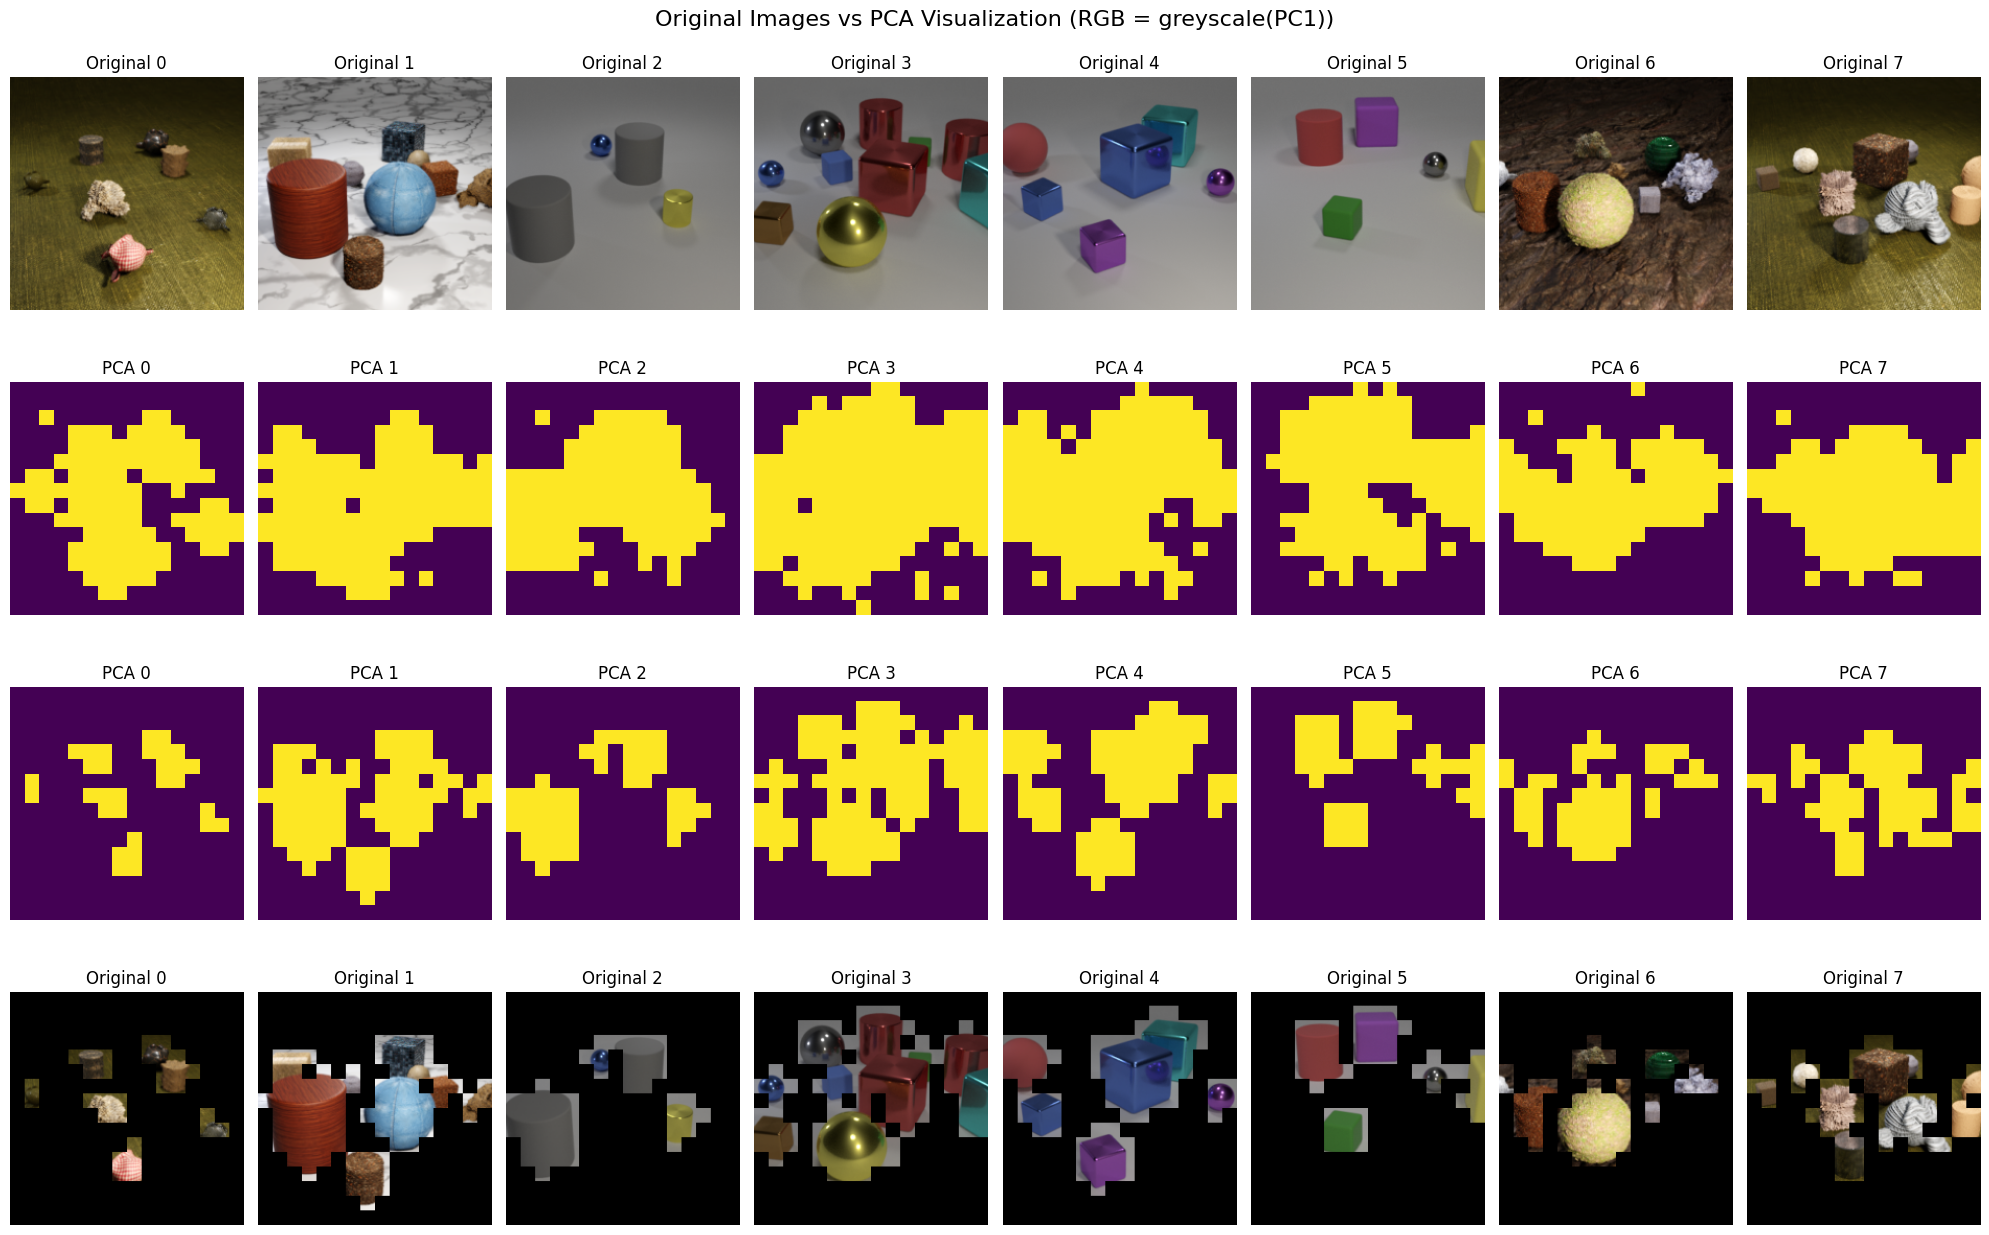

In [29]:
batch = next(it)
images = batch["image"]  # torch.Size([8, 3, 224, 224])

with torch.no_grad():
    segmented_images, mask, backbone_patches, rough_mask = pre_processor.segment_images(images.cuda(), add_opt_outputs=True)

mask = mask.reshape((8, 1, 16, 16))
rough_mask = rough_mask.reshape((8, 1, 16, 16))
backbone_patches = backbone_patches.reshape((8, 16, 16, 384))
# backbone_patches = backbone_patches.reshape((8, 16, 16, 768))
backbone_patches = backbone_patches.reshape(batch_size * patch_h * patch_w, -1)

# Visualize results
fig, axes = plt.subplots(4, 8, figsize=(20, 13))
# fig.suptitle('Original Images vs PCA Visualization (RGB = PC1, PC2, PC3)', fontsize=16)
fig.suptitle("Original Images vs PCA Visualization (RGB = greyscale(PC1))", fontsize=16)

for i in range(8):
    # Original image
    img = images[i].cpu().permute(1, 2, 0).numpy()
    img = (img - img.min()) / (img.max() - img.min() + 1e-8)
    axes[0, i].imshow(img)
    axes[0, i].axis("off")
    axes[0, i].set_title(f"Original {i}")

    # rough mask visualization (16x16 will be upsampled by imshow)
    rough_mask_img = rough_mask[i].float().cpu().permute(1, 2, 0).numpy()
    axes[1, i].imshow(rough_mask_img, interpolation="nearest")
    axes[1, i].axis("off")
    axes[1, i].set_title(f"PCA {i}")

    # mask visualization (16x16 will be upsampled by imshow)
    mask_img = mask[i].float().cpu().permute(1, 2, 0).numpy()
    axes[2, i].imshow(mask_img, interpolation="nearest")
    axes[2, i].axis("off")
    axes[2, i].set_title(f"PCA {i}")

    # final segmented image visualization
    segmented_img = segmented_images[i].cpu().permute(1, 2, 0).numpy()
    segmented_img = (segmented_img - segmented_img.min()) / (segmented_img.max() - segmented_img.min() + 1e-8)
    axes[3, i].imshow(segmented_img)
    axes[3, i].axis("off")
    axes[3, i].set_title(f"Original {i}")

plt.tight_layout()
plt.show()

# Visualizing reconstruction performance on object patches

In [30]:
with torch.no_grad():
    global_features, object_patches, mask = pre_processor.get_global_features_and_patches(
        images.cuda()
    )

    recon_patches, mean, logvar = model.encode_decode_object_patches(object_patches, mask)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.00062550255..0.9998214].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.000111619585..1.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.0035258166..0.9578632].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.001713905..0.9988378].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.010433816..1.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.0010632203..0.9967191].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0

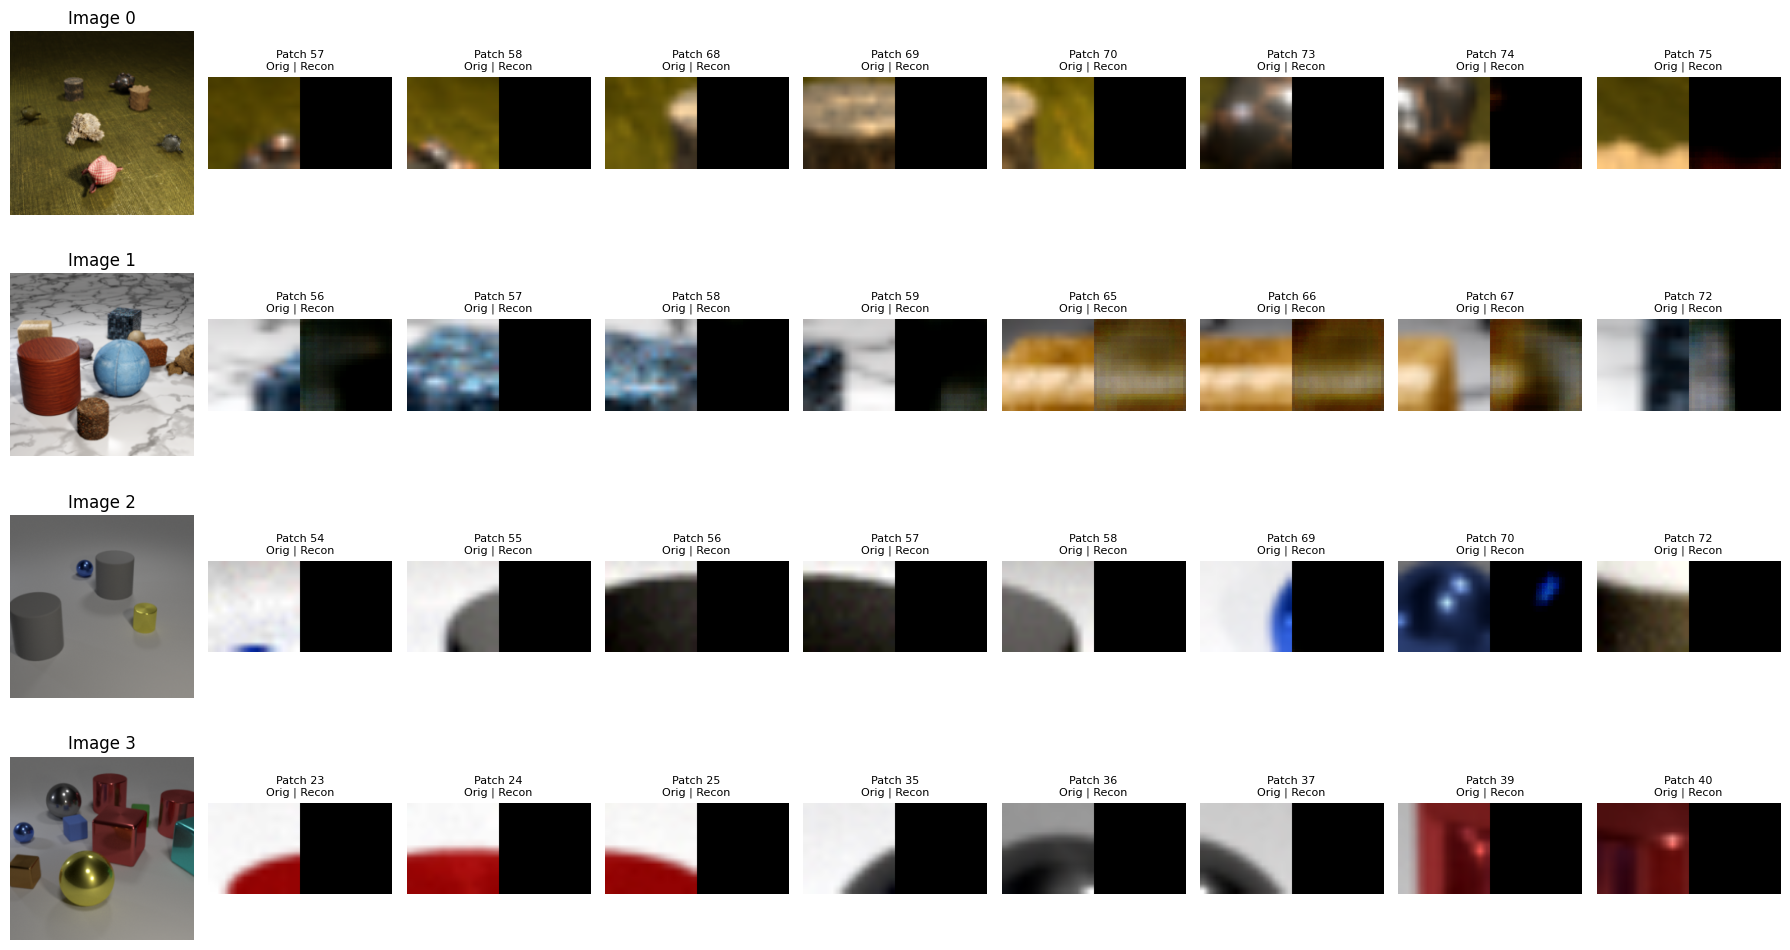

In [34]:
# Parameters
num_images_to_show = 4  # Number of images from batch to visualize
num_patches_per_image = 8  # Number of patches to show per image

# Select subset of images to display
images_to_plot = min(num_images_to_show, images.shape[0])

fig, axes = plt.subplots(images_to_plot, num_patches_per_image + 1, 
                         figsize=(2 * (num_patches_per_image + 1), 2.5 * images_to_plot))

if images_to_plot == 1:
    axes = axes.reshape(1, -1)

# Build a mapping from (batch_idx, patch_idx) to reconstruction index
# recon_patches corresponds to object_patches[mask]
recon_map = {}
recon_idx = 0
for img_idx in range(mask.shape[0]):
    for patch_idx in range(mask.shape[1]):
        if mask[img_idx, patch_idx] == 1:  # masked patches have reconstructions
            recon_map[(img_idx, patch_idx)] = recon_idx
            recon_idx += 1

for img_idx in range(images_to_plot):
    # Plot original image
    img = images[img_idx].permute(1, 2, 0).cpu().numpy()
    img = (img - img.min()) / (img.max() - img.min())  # Simple normalization
    
    axes[img_idx, 0].imshow(img)
    axes[img_idx, 0].set_title(f'Image {img_idx}')
    axes[img_idx, 0].axis('off')
    
    # Get MASKED patch indices for this image (these have reconstructions)
    masked_indices = torch.where(mask[img_idx] == 1)[0]
    
    # Select patches to display
    patches_to_show = min(num_patches_per_image, len(masked_indices))
    selected_patches = masked_indices[:patches_to_show]
    
    for patch_idx in range(num_patches_per_image):
        ax = axes[img_idx, patch_idx + 1]
        
        if patch_idx < patches_to_show:
            global_patch_idx = selected_patches[patch_idx]
            
            # Get object patch
            obj_patch = object_patches[img_idx, global_patch_idx].permute(1, 2, 0).cpu().numpy()
            obj_patch = (obj_patch - obj_patch.min()) / (obj_patch.max() - obj_patch.min())
            
            # Get reconstruction patch using the mapping
            recon_idx = recon_map[(img_idx, global_patch_idx.item())]
            recon_patch = recon_patches[recon_idx].permute(1, 2, 0).cpu().numpy()
            
            # Resize object patch for comparison (interpolate to 64x64)
            obj_patch_resized = torch.nn.functional.interpolate(
                torch.from_numpy(obj_patch).permute(2, 0, 1).unsqueeze(0),
                # size=(16, 16), mode='bilinear', align_corners=False
                size=(64, 64), mode='bilinear', align_corners=False
            )[0].permute(1, 2, 0).numpy()

            recon_patch = (recon_patch - obj_patch_resized.min()) / (obj_patch_resized.max() - obj_patch_resized.min())
            
            # Create side-by-side comparison
            combined = torch.cat([
                torch.from_numpy(obj_patch_resized),
                torch.from_numpy(recon_patch)
            ], dim=1).numpy()
            
            ax.imshow(combined)
            ax.set_title(f'Patch {global_patch_idx.item()}\nOrig | Recon', fontsize=8)
        else:
            ax.axis('off')
        
        ax.axis('off')

plt.tight_layout()
plt.show()